# FineTune_LR_scheduler - S5_v6


# Target:

1. FineTune LR scheduler. Set LR=0.1 as before but updated StepSize = 12 and Gamma = 0.2

# Results:

1. Parameters: 7,612
2. Best Train Accuracy: 99.41
3. Best Test Accuracy: 99.49

# Analysis:
1. To get best combination values StepSize = 12 and Gamma =0.2, we tried many trails of these two values.
2. The intuition behind above values is, we observed the accuracy is gradually increasing till around 10 epochs and getting stall from there. So we would like to update LR around 10-12 epochs.
3. We tried with StepSize and Gamma combinations - (10, 0.1), (11, 0.1), (12, 0.1) But didn't help to get the target accuracy consistently at last few epochs.
4. So we thought to increase the speed a little bit after 10-12 epochs by updating gamma = 0.2 and tried these StepSize and Gamma combinations - (10, 0.2), (11, 0.2), (12, 0.2) And finaally Stepsize=12, Gamma=0.2 gave best consistency of >=99.4% in the last 3 epochs and hit maximum of 99.49% with less than 8000 parameters


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [ ]:
num_splits = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=32, num_splits=num_splits)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10, num_splits=num_splits)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



cuda


In [ ]:
model = Net().to(device)

In [ ]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock5): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), 

In [ ]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
   GhostBatchNorm-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
   GhostBatchNorm-13           [-1, 16, 10, 10]              32
           Conv2d-14             [-1, 3

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 15
scheduler = StepLR(optimizer, step_size=12, gamma=0.2)

for epoch in range(EPOCHS):
    print(f" ***** EPOCH:{epoch} ***** ")
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

 ***** EPOCH:0 ***** 


Loss=0.09717582911252975 Batch_id=468 Accuracy=93.33: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9817/10000 (98.17%)

 ***** EPOCH:1 ***** 


Loss=0.048828840255737305 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9839/10000 (98.39%)

 ***** EPOCH:2 ***** 


Loss=0.0321931466460228 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9889/10000 (98.89%)

 ***** EPOCH:3 ***** 


Loss=0.0407191626727581 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9873/10000 (98.73%)

 ***** EPOCH:4 ***** 


Loss=0.08519145846366882 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9892/10000 (98.92%)

 ***** EPOCH:5 ***** 


Loss=0.030831528827548027 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9900/10000 (99.00%)

 ***** EPOCH:6 ***** 


Loss=0.05501667037606239 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9907/10000 (99.07%)

 ***** EPOCH:7 ***** 


Loss=0.061720605939626694 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9925/10000 (99.25%)

 ***** EPOCH:8 ***** 


Loss=0.02112383395433426 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9923/10000 (99.23%)

 ***** EPOCH:9 ***** 


Loss=0.07669911533594131 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

 ***** EPOCH:10 ***** 


Loss=0.03665235638618469 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

 ***** EPOCH:11 ***** 


Loss=0.049752939492464066 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

 ***** EPOCH:12 ***** 


Loss=0.060340072959661484 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

 ***** EPOCH:13 ***** 


Loss=0.05717821046710014 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9947/10000 (99.47%)

 ***** EPOCH:14 ***** 


Loss=0.03329988196492195 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]



Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

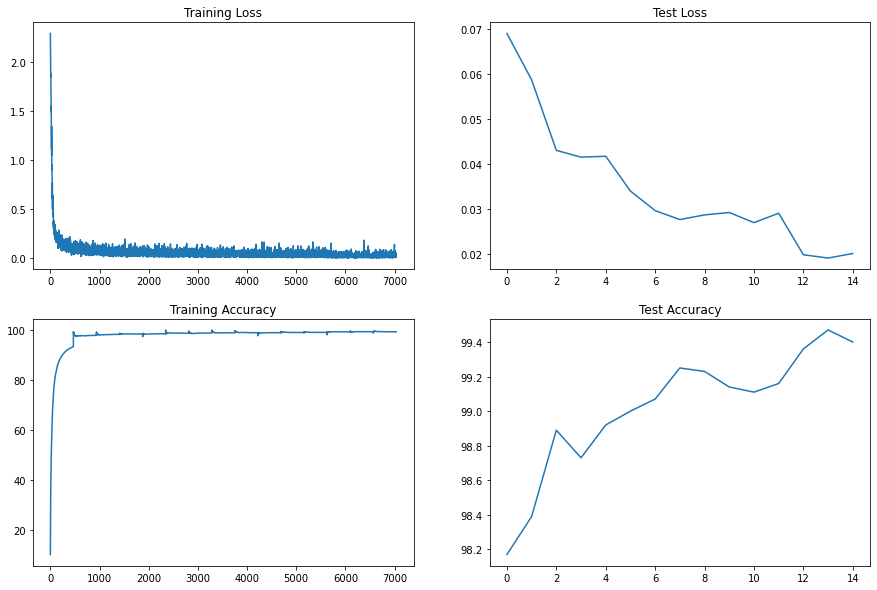

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")